# Amazon SageMaker Semantic Segmentation Algorithm - v5

In [1]:
dryrun = True
install = False

In [2]:
%%bash -s $install
source ~/git/awesome-bash-cli/abcli/.abcli/abcli.sh in_notebook

install=$1

if [[ "$install" == True ]] ; then
    cd ~/git/awesome-bash-cli
    pip3 install -e .

    cd ~/git/notebooks-and-scripts
    pip3 install -e .

    pip3 install 'sagemaker>=2,<3'
fi

🔋 gpu: not found.
🚀 abcli-7.2670.1.2023-06-aws-batch-a


In [28]:
import os
os.environ["abcli_path_bash"] = "{}/git/awesome-bash-cli/bash".format(os.getenv("HOME"))

import sagemaker
import time
from abcli import file, path
from abcli import fullname
from abcli import string
from abcli.modules.objects import unique_object
from abcli.plugins.storage import instance as storage
from notebooks_and_scripts.sagemaker import role
from notebooks_and_scripts.sagesemseg.dataset import upload as upload_dataset
from abcli.modules import objects
from roofAI.logger import logger


logger.info(f"{fullname()}, built on {string.pretty_date()}")

abcli-7.2670.1-unknown, built on 04 February 2024, 18:58:10


In [4]:
# sagesemseg upload_dataset - suffix=full-v2
dataset_object_name = "pascal-voc-v1-full-v2"

if dryrun:
    # sagesemseg upload_dataset - suffix=debug-v2 --count 16
    dataset_object_name = "pascal-voc-v1-debug-v2"

logger.info(f"dataset_object_name: {dataset_object_name}")
model_object_name = unique_object("sagesemseg-model")

dataset_object_name: pascal-voc-v1-debug-v2
📂 sagesemseg-model-2024-02-04-18-38-44-12308


In [5]:
%%bash -s $dataset_object_name
source ~/git/awesome-bash-cli/abcli/.abcli/abcli.sh in_notebook

dataset_object_name=$1

abcli download filename=metadata.yaml $dataset_object_name

🔋 gpu: not found.
🚀 abcli-7.2670.1.2023-06-aws-batch-a
downloading pascal-voc-v1-debug-v2/metadata.yaml ...
download: s3://kamangir/bolt/pascal-voc-v1-debug-v2/metadata.yaml to ../../../../../storage/abcli/pascal-voc-v1-debug-v2/metadata.yaml
download completed: pascal-voc-v1-debug-v2 metadata.yaml


In [6]:
%%time
sess = sagemaker.Session()

CPU times: user 30.1 ms, sys: 6.28 ms, total: 36.4 ms
Wall time: 39.1 ms


In [7]:
metadata_filename = objects.path_of(object_name = dataset_object_name, filename = "metadata.yaml")
success, metadata = file.load_yaml(metadata_filename)
assert success

logger.info(f"dataset_object_name: {dataset_object_name}")

dataset_object_name: pascal-voc-v1-debug-v2


In [8]:
training_image = sagemaker.image_uris.retrieve("semantic-segmentation", sess.boto_region_name)
logger.info(f"training_image: {training_image}")

Same images used for training and inference. Defaulting to image scope: inference.
Defaulting to the only supported framework/algorithm version: 1.
Ignoring unnecessary instance type: None.
training_image: 469771592824.dkr.ecr.ca-central-1.amazonaws.com/semantic-segmentation:1


In [9]:
ss_estimator = sagemaker.estimator.Estimator(
    training_image,  # Container image URI
    role,  # Training job execution role with permissions to access our S3 bucket
    instance_count=1,
    instance_type="ml.p3.2xlarge",
    volume_size=50,  # in GB
    max_run=360000,  # in seconds
    output_path=f"s3://kamangir/bolt/{model_object_name}",
    base_job_name=model_object_name,
    sagemaker_session=sess,
)

In [10]:
# Setup hyperparameters
ss_estimator.set_hyperparameters(
    backbone="resnet-50",  # This is the encoder. Other option is resnet-101
    algorithm="fcn",  # This is the decoder. Other options are 'psp' and 'deeplab'
    use_pretrained_model="True",  # Use the pre-trained model.
    crop_size=240,  # Size of image random crop.
    num_classes=21,  # Pascal has 21 classes. This is a mandatory parameter.
    epochs=10,  # Number of epochs to run.
    learning_rate=0.0001,
    optimizer="rmsprop",  # Other options include 'adam', 'rmsprop', 'nag', 'adagrad'.
    lr_scheduler="poly",  # Other options include 'cosine' and 'step'.
    mini_batch_size=16,  # Setup some mini batch size.
    validation_mini_batch_size=16,
    early_stopping=True,  # Turn on early stopping. If OFF, other early stopping parameters are ignored.
    early_stopping_patience=2,  # Tolerate these many epochs if the mIoU doens't increase.
    early_stopping_min_epochs=10,  # No matter what, run these many number of epochs.
    num_training_samples=metadata["num"]["train"], # num_training_samples,  # This is a mandatory parameter, 1464 in this case.
)

In [11]:
distribution = "FullyReplicated"

data_channels = {
    "train": sagemaker.inputs.TrainingInput(
        metadata["channel"]["train"], #train_channel, 
        distribution=distribution,
    ),
    "validation": sagemaker.inputs.TrainingInput(
        metadata["channel"]["validation"], #validation_channel, 
        distribution=distribution,
    ),
    "train_annotation": sagemaker.inputs.TrainingInput(
        metadata["channel"]["train_annotation"], #train_annotation_channel, 
        distribution=distribution
    ),
    "validation_annotation": sagemaker.inputs.TrainingInput(
        metadata["channel"]["validation_annotation"], #validation_annotation_channel, 
        distribution=distribution,
    ),
    # 'label_map': metadata["channel"]["label_map"], # label_map_channel
}

In [12]:
ss_estimator.fit(data_channels, logs=True)

Creating training-job with name: sagesemseg-model-2024-02-04-18-38-44-12-2024-02-05-02-38-50-099


2024-02-05 02:38:50 Starting - Starting the training job......
2024-02-05 02:39:26 Starting - Preparing the instances for training...
2024-02-05 02:40:17 Downloading - Downloading input data...
2024-02-05 02:40:42 Downloading - Downloading the training image..................
2024-02-05 02:43:43 Training - Training image download completed. Training in progress...Docker entrypoint called with argument(s): train
Running default environment configuration script
Nvidia gpu devices, drivers and cuda toolkit versions (only available on hosts with GPU):
Mon Feb  5 02:44:09 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.12             Driver Version: 535.104.12   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Me

In [13]:
ss_predictor = ss_estimator.deploy(initial_instance_count=1, instance_type="ml.c5.xlarge")

Creating model with name: sagesemseg-model-2024-02-04-18-38-44-12-2024-02-05-02-45-16-304
Creating endpoint-config with name sagesemseg-model-2024-02-04-18-38-44-12-2024-02-05-02-45-16-304
Creating endpoint with name sagesemseg-model-2024-02-04-18-38-44-12-2024-02-05-02-45-16-304


---------------!

In [35]:
path.create(objects.path_of(object_name = model_object_name, filename = "validation/"))
filename_raw = objects.path_of(object_name = model_object_name, filename = "validation/test.jpg")

!wget -O $filename_raw https://github.com/kamangir/blue-bracket/raw/main/images/helmet-1.jpg

--2024-02-04 19:03:28--  https://github.com/kamangir/blue-bracket/raw/main/images/helmet-1.jpg
Resolving github.com (github.com)... 140.82.113.4
Connecting to github.com (github.com)|140.82.113.4|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/kamangir/blue-bracket/main/images/helmet-1.jpg [following]
--2024-02-04 19:03:29--  https://raw.githubusercontent.com/kamangir/blue-bracket/main/images/helmet-1.jpg
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 2606:50c0:8003::154, 2606:50c0:8000::154, 2606:50c0:8001::154, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|2606:50c0:8003::154|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 1385654 (1.3M) [image/jpeg]
Saving to: ‘/Users/kamangir/storage/abcli/sagesemseg-model-2024-02-04-18-38-44-12308/validation/test.jpg’

/Users/kamangir/sto 100%[===================>]   1.32M  --.-KB/s    in 0.1s    

2024-02-04 19:

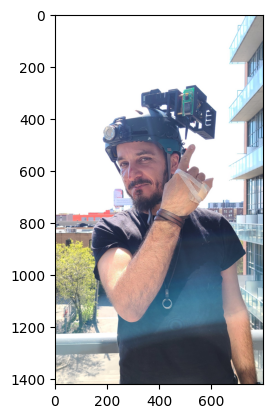

In [36]:
from matplotlib import pyplot as plt
import PIL

%matplotlib inline

filename = objects.path_of(object_name = model_object_name, filename = "validation/test_resized.jpg")
width = 800

im = PIL.Image.open(filename_raw)

aspect = im.size[0] / im.size[1]

# https://stackoverflow.com/a/14351890/17619982
im.thumbnail([width, int(width / aspect)], PIL.Image.LANCZOS)
im.save(filename, "JPEG")

plt.imshow(im)
plt.show()

In [37]:
from PIL import Image
import numpy as np


class ImageDeserializer(sagemaker.deserializers.BaseDeserializer):
    """Deserialize a PIL-compatible stream of Image bytes into a numpy pixel array"""

    def __init__(self, accept="image/png"):
        self.accept = accept

    @property
    def ACCEPT(self):
        return (self.accept,)

    def deserialize(self, stream, content_type):
        """Read a stream of bytes returned from an inference endpoint.
        Args:
            stream (botocore.response.StreamingBody): A stream of bytes.
            content_type (str): The MIME type of the data.
        Returns:
            mask: The numpy array of class labels per pixel
        """
        try:
            return np.array(Image.open(stream))
        finally:
            stream.close()


ss_predictor.deserializer = ImageDeserializer(accept="image/png")

In [38]:
ss_predictor.serializer = sagemaker.serializers.IdentitySerializer("image/jpeg")

with open(filename, "rb") as imfile:
    imbytes = imfile.read()

# Extension exercise: Could you write a custom serializer which takes a filename as input instead?

22 second(s) -> 1422x800:uint8: [ 0  1  2  3  4  5  7  8  9 10 11 12 13 14 15 19 20]


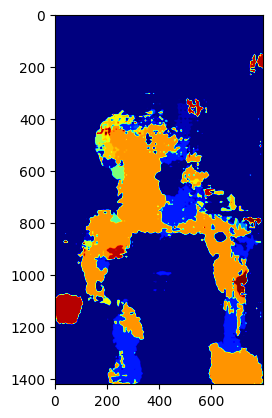

In [39]:
start_time = time.time()
cls_mask = ss_predictor.predict(imbytes)
elapsed_time = time.time() - start_time

logger.info("{} -> {}: {}".format(
    string.pretty_duration(elapsed_time),
    string.pretty_shape_of_matrix(cls_mask),
    np.unique(cls_mask),
))

plt.imshow(cls_mask, cmap="jet")
plt.savefig(objects.path_of(object_name = model_object_name, filename = "validation/output.jpg"))
plt.show()

In [41]:
# assert False
ss_predictor.delete_endpoint()

Deleting endpoint configuration with name: sagesemseg-model-2024-02-04-18-38-44-12-2024-02-05-02-45-16-304
Deleting endpoint with name: sagesemseg-model-2024-02-04-18-38-44-12-2024-02-05-02-45-16-304


In [40]:
%%bash -s $model_object_name
source ~/git/awesome-bash-cli/abcli/.abcli/abcli.sh in_notebook

model_object_name=$1

abcli_upload - $model_object_name

🔋 gpu: not found.
🚀 abcli-7.2670.1.2023-06-aws-batch-a
confirmed: sagesemseg-model-2024-02-04-18-38-44-12308 does not exist.
sagesemseg-model-2024-02-04-18-38-44-12308 open upload started.
upload: ../../../../../storage/abcli/sagesemseg-model-2024-02-04-18-38-44-12308/validation/output.jpg to s3://kamangir/bolt/sagesemseg-model-2024-02-04-18-38-44-12308/validation/output.jpg
upload: ../../../../../storage/abcli/sagesemseg-model-2024-02-04-18-38-44-12308/validation/test_resized.jpg to s3://kamangir/bolt/sagesemseg-model-2024-02-04-18-38-44-12308/validation/test_resized.jpg
upload: ../../../../../storage/abcli/sagesemseg-model-2024-02-04-18-38-44-12308/validation/test.jpg to s3://kamangir/bolt/sagesemseg-model-2024-02-04-18-38-44-12308/validation/test.jpg


sagesemseg-model-2024-02-04-18-38-44-12308 += #open.


In [42]:
# END